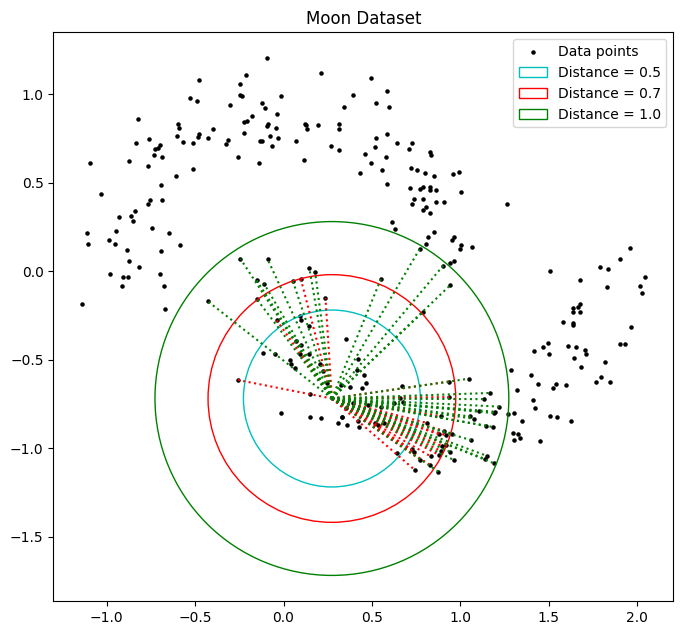

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from util import moon
from sklearn.metrics import pairwise_distances

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 32))

n, noise = 500, 0.3
data, length = moon(n, noise)
x = data[:, 0]
y = data[:, 1]

DISTANCES = [0.5, 0.7, 1.0]
COLORS = ['c', 'r', 'g']

# Select a reference point (point 250)
p_200 = data[250]

# Compute pairwise distances between all points and the reference point
distances = pairwise_distances(data, [p_200])

# Plot scatter plot of the data points
ax.scatter(x, y, c='black', s=5, label="Data points")

# Draw circles and connect nearby points
for i, distance in enumerate(DISTANCES):
    circle = plt.Circle((p_200[0], p_200[1]), distance, color=COLORS[i], fill=False, label=f'Distance = {distance}')
    ax.add_patch(circle)  # Add the circle to the axis

    # Find points within the distance range and plot lines to connect them
    nearby_points = np.where((distances < distance) & (distances >= DISTANCES[i - 1] if i > 0 else 0))[0]
    
    for j in nearby_points:
        if j != 300:  # Avoid connecting to the same point
            ax.plot([p_200[0], data[j, 0]], [p_200[1], data[j, 1]], color=COLORS[i], linestyle='dotted')

# Set aspect ratio to be equal for both axes
ax.set_aspect('equal', adjustable='box')
ax.set_title("Moon Dataset")

# Add legend
ax.legend()

# Show the plot
plt.show()


Distance = 0.3, Number of edges = 2892
Distance = 0.5, Number of edges = 5886
Distance = 1.0, Number of edges = 14744


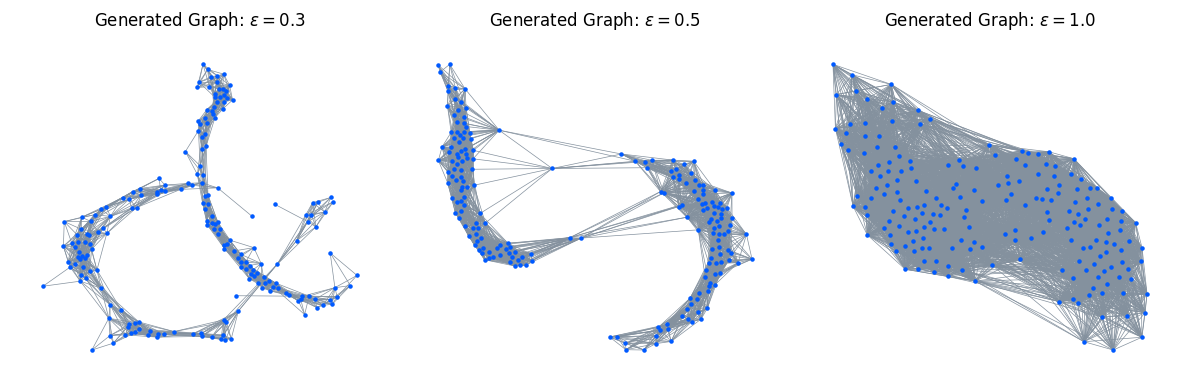

In [18]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
import torch

# from util import Net, GIN, GAT, moon, stationary, reconstruct, dG
from util import moon

fig = plt.figure(figsize=(12, 4)) 

np.random.seed(0)
torch.manual_seed(0)

n = 200
noise = 0.5
DISTANCES = [0.3, 0.5, 1.0] 

x, n = moon(n, noise)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))

D = pairwise_distances(x)

for i, DISTANCE in enumerate(DISTANCES):
    A_binary = np.where((D <= DISTANCE) & (D != 0), 1, 0)
    
    fr, to = np.where(A_binary == 1)
    edges = list(zip(fr, to))
    
    print(f"Distance = {DISTANCE}, Number of edges = {len(edges)}")
    
    G = nx.Graph()
    G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
    
    pos = nx.spring_layout(G, k=0.18, seed=0)
    
    plt.subplot(1, 3, i + 1) 
    nx.draw(G, pos=pos, node_size=5, node_color='#005aff', edge_color='#84919e', width=0.5)
    plt.title(rf"$\text{{Generated Graph: }} \epsilon = {DISTANCE}$", fontsize=12)  

plt.tight_layout()
plt.show()
